# Tabular Methods Practical

## Introduction

In this practical, you will implement two tabular methods of reinforcement learning: [Q-Learning](https://en.wikipedia.org/wiki/Q-learning) and [Sarsa](https://en.wikipedia.org/wiki/State–action–reward–state–action) according to Sutton and Barto's book. Our implementation will be based on a simple [RLAgent](rl/agent.py) class provided by the instructor, and the simplest of the [Gym](https://github.com/openai/gym) environments.

<div class="alert alert-block alert-warning">
You will need to configure your environment following the instructions in the `README.md` file included in this repository.
</div>

## The agent interface

In this notebook we will use a basic agent interface called [`RLAgent`](src/rl/agent.py). Open this file and become familiar with its key attributes and methods. 

The key attributes you will need for this notebook are the following:
- `self.env` — a reference to the [environment from gym](https://github.com/openai/gym/blob/58ed658d9b15fd410c50d1fdb25a7cad9acb7fa4/gym/core.py#L8);
- `self.episodes` — the number of episodes to train the agent when invoking [`RLAgent.learn()`](rl/agent.py#L125);
- `self.alpha` — the *learning rate* to be used when computing the RL update;
- `self.gamma` — the *discount factor* for the return computed during training; and
- `self.q_table` — a dictionary of lists of floating point numbers indexed by the state and an action (e.g., `self.q_table[state][action]` should return the q-value of the `state`-`action` pair)
- `self.actions` — an integer representing the size of the action space
- `self.last_state` — the last state visited by the agent during learning
- `self.last_action` — the last action chosen by the agent during learning
- `self._random` — a reference to a Python [Random](https://docs.python.org/3/library/random.html#random.Random) object.

Pay attention to the `self.random` object, and use it instead of the unbound methods from Python's [random library](https://docs.python.org/3/library/random.html), otherwise the tests will not work. 

The key methods you should be aware of are the following:
- [`policy`](rl/agent.py#L90) — returns the greedy policy following the currently learned q-values;
- [`epsilon_greedy_policy`](rl/agent.py#L101) — returns an $\epsilon$-greedy policy;
- [`agent_start`](rl/agent.py#L55) — the method to be called once *before each episode*;
- [`agent_step`](rl/agent.py#L67) — the method to be called once at *each time step* within an episode;
- [`agent_end`](rl/agent.py#L80) — the method to be called once at the *end of each episode* when the agent reaches a *terminal state*; and
- [`learn`](rl/agent.py#L125) — runs the underlying learning algorithm for `self.episodes` episodes

## Greedy and $\epsilon$-Greedy Policies

In the cell below, you need to implement both the greedy and the $\epsilon$-greedy policy using the q-values stored in `self.q_table` and the $\epsilon$ from `self.eps()`. 

Recall the definition of $\epsilon$-greedy policy:

For all $a \in \mathcal{A}$
$$\pi(a \mid S_t) = \begin{cases} 1 - \epsilon +\frac{\epsilon}{|\mathcal{A}|} & \text{if}~a = A^* \\ \frac{\epsilon}{|\mathcal{A}|} & \text{if}~a \neq A^*\end{cases}$$
where $A^* = \arg\max_{a}Q(S_t,a)$, with ties broken randomly (this is the greedy policy).

In [26]:
import gym
import numpy as np
from rl.agent import RLAgent, Action, State
from random import Random
from gym import Env
from typing import Any, Collection, List, NoReturn, Sequence

class TabularQLearner(RLAgent):
    """
    A simple Tabular Q-Learning agent.
    """
    def __init__(self,
                 env: Env,
                 episodes: int = 500,
                 decaying_eps: bool = True,
                 eps: float = 1.0,
                 alpha: float = 0.5,
                 decay: float = 0.000002,
                 gamma: float = 0.9,
                 rand: Random = Random(),
                 **kwargs):
        super().__init__(env, episodes=episodes, decaying_eps=decaying_eps, eps=eps, alpha=alpha, decay=decay, gamma=gamma, rand=rand)
        self.actions = env.action_space.n
        self.q_table = {}

        # hyperparameters
        self.episodes = episodes
        self.gamma = gamma
        self.decay = decay
        self.c_eps = eps
        self.base_eps = eps
        if decaying_eps:
            def epsilon():
                self.c_eps = max((self.episodes - self.step)/self.episodes, 0.01)
                return self.c_eps
            self.eps = epsilon
        else:
            self.eps = lambda: eps
        self.decaying_eps = decaying_eps
        self.alpha = alpha
        self.last_state = None
        self.last_action = None
    
    def add_new_state(self, state: State):
        # self.q_table[state] = [1. for _ in range(self.actions)]
        self.q_table[state] = [0.]*self.actions

    def get_all_q_values(self, state: State) -> List[float]:
        if state in self.q_table:
            return self.q_table[state]
        else:
            return [0.]*self.actions

    def best_actions(self, state: State) -> Sequence[int]:
        """Returns a list with the best actions for a particular state

        Args:
            state (State): The state for which we need the best actions

        Returns:
            Sequence[int]: a list with the best actions
        """
        if state not in self.q_table:
            self.add_new_state(state)
        q_next = np.array(self.q_table[state])
        best_actions = np.argwhere(q_next == np.max(q_next)).flatten()
        return best_actions

    def best_action(self, state: State) -> Action:
        """Returns the best action for a state, breaking ties randomly

        Args:
            state (State): The state in which to extract the best action

        Returns:
            int: The index of the best action
        """
        if state not in self.q_table:
            self.add_new_state(state)
            # self.q_table[state] = [0 for _ in range(self.actions)]
        # return np.argmax(self.q_table[state])
        best_actions = self.best_actions(state)

        return self._random.choice(best_actions)
    
    def policy(self, state: State) -> Action:
        """Returns the greedy deterministic policy for the specified state
        
        Args:
            state (State): the state for which we want the action

        Raises:
            InvalidAction: Not sure about this one

        Returns:
            Any: The greedy action learned for state
        """
        ## YOUR CODE HERE
        return self.best_action(state)
        ## END CODE
        
    def epsilon_greedy_policy(self, state: State) -> Action:
        """Returns the epsilon-greedy policy
        
        Args:
            state (State): The state for which to return the epsilon greedy policy

        Returns:
            Any: The action to be taken
        """
        ## YOUR CODE HERE
        if self._random.random() < self.eps():
            return self._random.choice(list(range(self.actions)))
        else:
            return self.best_action(state)
        ## END CODE


In [27]:
env = gym.make("CliffWalking-v0")
agent = TabularQLearner(env=env, decaying_eps=False, eps=0.5, rand = Random(42))
agent.q_table["a"] = [1, 0.5, 4, 0]
agent.q_table["b"] = [0, 1, 0, 0.5]

action_a = agent.epsilon_greedy_policy("a")
action_b = agent.epsilon_greedy_policy("b")
print(f"Action for a={action_a}")
print(f"Action for b={action_b}")

assert(action_a == 2)
assert(action_b == 1)

action_a = agent.epsilon_greedy_policy("a")
action_b = agent.epsilon_greedy_policy("b")

print(f"Action for a={action_a}")
print(f"Action for b={action_b}")

assert(action_a == 0)  # With our random seed, this one should be exploratory
assert(action_b == 1)

Action for a=2
Action for b=1
Action for a=0
Action for b=1


## Q-Learning

**Description** 

Q-Learning is an off policy algorithm that learns the target policy by temporal-difference from a greedy target policy using the following update rule. In our implementation, we will use the $\epsilon$-greedy policy as the source policy. 

$$ Q(S,A) \gets Q(S,A) + \alpha \left(R + \gamma\max_{a'}Q(S',a') - Q(S,A) \right) $$ 

In the cell below, you should implement the following methods (as noted in the source code):
- `policy` and `epsilon_greedy_policy` - copy the code you just developed above
- `agent_start` - initialize the last state with the initial state given by the environment and choose one initial action
- `agent_step` - this should follow the algorithm in Section 6.5 from Sutton and Barto
- `agent_end` - one last update at the end of the episode, but using just the old value of Q as the TD-error

In [64]:
class TabularQLearner(RLAgent):
    """
    A simple Tabular Q-Learning agent.
    """
    def __init__(self,
                 env: Env,
                 episodes: int = 500,
                 decaying_eps: bool = True,
                 eps: float = 1.0,
                 alpha: float = 0.5,
                 decay: float = 0.000002,
                 gamma: float = 0.9,
                 rand: Random = Random(),
                 **kwargs):
        super().__init__(env, episodes=episodes, decaying_eps=decaying_eps, eps=eps, alpha=alpha, decay=decay, gamma=gamma, rand=rand)
        self.actions = env.action_space.n
        self.q_table = {}

        # hyperparameters
        self.episodes = episodes
        self.gamma = gamma
        self.decay = decay
        self.c_eps = eps
        self.base_eps = eps
        if decaying_eps:
            def epsilon():
                self.c_eps = max((self.episodes - self.step)/self.episodes, 0.01)
                return self.c_eps
            self.eps = epsilon
        else:
            self.eps = lambda: eps
        self.decaying_eps = decaying_eps
        self.alpha = alpha
        self.last_state = None
        self.last_action = None

    def add_new_state(self, state: State):
        # self.q_table[state] = [1. for _ in range(self.actions)]
        self.q_table[state] = [0.]*self.actions

    def get_all_q_values(self, state: State) -> List[float]:
        if state in self.q_table:
            return self.q_table[state]
        else:
            return [0.]*self.actions

    def best_actions(self, state: State) -> Sequence[int]:
        """Returns a list with the best actions for a particular state

        Args:
            state (State): The state for which we need the best actions

        Returns:
            Sequence[int]: a list with the best actions
        """
        if state not in self.q_table:
            self.add_new_state(state)
        q_next = np.array(self.q_table[state])
        best_actions = np.argwhere(q_next == np.max(q_next)).flatten()
        return best_actions

    def best_action(self, state: State) -> Action:
        """Returns the best action for a state, breaking ties randomly

        Args:
            state (State): The state in which to extract the best action

        Returns:
            int: The index of the best action
        """
        if state not in self.q_table:
            self.add_new_state(state)
            # self.q_table[state] = [0 for _ in range(self.actions)]
        # return np.argmax(self.q_table[state])
        best_actions = self.best_actions(state)

        return self._random.choice(best_actions)
    
    def get_max_q(self, state: State) -> float:
        if state not in self.q_table:
            self.add_new_state(state)
        return np.max(self.q_table[state])
    
    def set_q_value(self, state: State, action: Any, q_value: float):
        if state not in self.q_table:
            self.add_new_state(state)
        self.q_table[state][action] = q_value

    def get_q_value(self, state: State, action: Any) -> float:
        if state not in self.q_table:
            self.add_new_state(state)
        return self.q_table[state][action]

    
    def policy(self, state: State) -> Action:
        """Returns the greedy deterministic policy for the specified state

        Args:
            state (State): the state for which we want the action

        Raises:
            InvalidAction: Not sure about this one

        Returns:
            Any: The greedy action learned for state
        """
        ## YOUR CODE HERE
        return self.best_action(state)
        ## END CODE

    def epsilon_greedy_policy(self, state: State) -> Action:
        """Returns the epsilon-greedy policy

        Args:
            state (State): The state for which to return the epsilon greedy policy

        Returns:
            Any: The action to be taken
        """
        ## YOUR CODE HERE
        if self._random.random() < self.eps():
            return self._random.randint(0, self.actions-1)
        else:
            return self.policy(state)
        ## END CODE

    def agent_start(self, state: State) -> Action:
        """The first method called when the experiment starts,
        called after the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's env_start function.
        Returns:
            (int) the first action the agent takes.
        """
        ## YOUR CODE HERE
        action = self.epsilon_greedy_policy(state)
        self.last_state = state
        self.last_action = action
        return action
        ## END CODE

    def agent_step(self, reward: float, state: State) -> Action:
        """A step taken by the agent.

        Args:
            reward (float): the reward received for taking the last action taken
            state (Any): the state from the
                environment's step based on where the agent ended up after the
                last step
        Returns:
            (int) The action the agent takes given this state.
        """
        ## YOUR CODE HERE
        
        # choose action
        action = self.epsilon_greedy_policy(state)

        # update q-table
        q_value = self.get_q_value(self.last_state, self.last_action)
        q_value = (1 - self.alpha) * q_value + self.alpha * (reward + self.gamma * self.get_max_q(state))
        self.set_q_value(self.last_state, self.last_action, q_value)
        
        # update last state and action
        self.last_state = state
        self.last_action = action
        
        return action
        ## END CODE

    def agent_end(self, reward: float) -> NoReturn:
        """Called when the agent terminates.

        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        ## YOUR CODE HERE
        # update q-table
        q_value = self.get_q_value(self.last_state, self.last_action)
        q_value = (1 - self.alpha) * q_value + self.alpha * (reward + self.gamma * self.get_max_q(self.last_state))
        self.set_q_value(self.last_state, self.last_action, q_value)
        ## END CODE

In [69]:
# Test for Q-Learning
## Mini test
nv = gym.make("CliffWalking-v0")
agent = TabularQLearner(env = env, decaying_eps=False, eps=0.5, rand = Random(42))
agent.q_table["a"] = [1, 0.5, 4, 0]
agent.q_table["b"] = [0, 1, 0, 0.5]

action_a = agent.agent_start("a")
assert(action_a == 2)

action_a = agent.agent_step(-1, "a")
# print(action_a)
# print(agent.q_table["a"])
# print(agent.q_table["b"])
assert(action_a == 2)
assert(agent.q_table["a"] == [1, 0.5, 3.3, 0])
assert(agent.q_table["b"] == [0, 1, 0, 0.5])

action_b = agent.agent_step(-2, "b")
# print(action_b)
# print(agent.q_table["a"])
# print(agent.q_table["b"])
assert(action_b == 0)
assert(np.where(np.isclose(agent.q_table["a"], [1, 0.5, 1.1, 0])))
assert(agent.q_table["b"] == [0, 1, 0, 0.5])

action_b = agent.agent_step(1, "b")
# print(action_b)
# print(agent.q_table["a"])
# print(agent.q_table["b"])
assert(action_b == 1)
assert(np.where(np.isclose(agent.q_table["a"], [1, 0.5, 1.1, 0])))
assert(agent.q_table["b"] == [0.95, 1, 0, 0.5])


## The Cliff Walking Environment
We are now ready to learn our first real policy for a non-trivial environment. At the end of training, we print the resulting policy. 

The environment we use is the Cliff Walking environment from Example 6.6 in Sutton and Barto's book. Refer to page 132 for further details, but we post a summary of the environment below for your convenience.
!["Cliff Sarsa"](cliff-sarsa.svg)

Why does the policy look the way it does (i.e., a bit random at times)?

In [66]:
##
from rl.env_utils import display_cliffwalking_policy
env = gym.make("CliffWalking-v0")
q_agent = TabularQLearner(env, episodes=500, gamma=1, eps=0.1, alpha=0.5, decaying_eps=False, rand=Random(42))
rewards_q = q_agent.learn()

print(f"Accumulated Reward: {np.sum(rewards_q)}")
# assert(np.sum(rewards_q) == -28481)
display_cliffwalking_policy(q_agent, env)

Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 422.45it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]

Accumulated Reward: -41238


→,↓,←,↓,←,←,←,↑,↓,↑,↑,↑
↓,↓,→,↑,↓,←,↓,↑,↑,↓,↓,→
↓,←,↑,↑,←,←,↓,↑,↓,↑,↓,↑
↓,↓,←,←,↑,↓,↓,↑,←,↑,↑,◎


## Sarsa

Sarsa is an on policy algorithm where the source and target policy are the same. In our implementation, we will use the $\epsilon$-greedy policy we implemented above.

$$ Q(S,A) \gets Q(S,A) + \alpha \left(R + \gamma Q(S',A') - Q(S,A) \right) $$ 

Note that we can implement Sarsa by simply subclassing the `TabularQLearner` class we just implemented. This time, the only modification we need is in the `agent_step` method. 

In [67]:
class TabularSarsaLearner(TabularQLearner):
    def agent_step(self, reward: float, state: State) -> Action:
        """A step taken by the agent.

        Args:
            reward (float): the reward received for taking the last action taken
            state (Any): the state from the
                environment's step based on where the agent ended up after the
                last step
        Returns:
            (int) The action the agent takes given this state.
        """
        ## YOUR CODE HERE
        # choose action
        action = self.epsilon_greedy_policy(state)

        # update q-table
        q_value = self.get_q_value(self.last_state, self.last_action)
        q_value = (1 - self.alpha) * q_value + self.alpha * (reward + self.gamma * self.get_q_value(state, action))
        self.set_q_value(self.last_state, self.last_action, q_value)

        # update last state and action
        self.last_state = state
        self.last_action = action

        return action
        ## END CODE

In [68]:
# Test for Sarsa

v = gym.make("CliffWalking-v0")
sarsa_agent = TabularSarsaLearner(env = env, decaying_eps=False, eps=0.5, rand = Random(42))
sarsa_agent.q_table["a"] = [1, 0.5, 4, 0]
sarsa_agent.q_table["b"] = [0, 1, 0, 0.5]

action_a = sarsa_agent.agent_start("a")
assert(action_a == 2)

action_a = sarsa_agent.agent_step(-1, "a")
# print(action_a)
# print(sarsa_agent.q_table["a"])
# print(sarsa_agent.q_table["b"])
assert(action_a == 2)
assert(sarsa_agent.q_table["a"] == [1, 0.5, 3.3, 0])
assert(sarsa_agent.q_table["b"] == [0, 1, 0, 0.5])

action_b = sarsa_agent.agent_step(-2, "b")
# print(action_b)
# print(sarsa_agent.q_table["a"])
# print(sarsa_agent.q_table["b"])
assert(action_b == 0)
assert(np.where(np.isclose(sarsa_agent.q_table["a"], [1, 0.5, 1.1, 0])))
assert(sarsa_agent.q_table["b"] == [0, 1, 0, 0.5])

action_b = sarsa_agent.agent_step(1, "b")
# print(action_b)
# print(sarsa_agent.q_table["a"])
# print(sarsa_agent.q_table["b"])
assert(action_b == 1)
assert(np.where(np.isclose(sarsa_agent.q_table["a"], [1, 0.5, 1.1, 0])))
assert(sarsa_agent.q_table["b"] == [0.95, 1, 0, 0.5])

## Expected Sarsa

Expected Sarsa is a variation of the Sarsa algorithm where, instead of computing the TD target using the actual samples from a stochastic source policy, we compute the expectation from that policy, much like the update rule in Dynamic Programming, using the following update

$$ Q(S,A) \gets Q(S,A) + \alpha \left(R + \gamma \sum_{a'}\pi(a'\mid S')Q(S',a') - Q(S,A) \right) $$ 

Like Sarsa, we can implement Expected Sarsa by simply subclassing the `TabularQLearner` class we just implemented. This time, the only modification we need is in the `agent_step` method. 

In [70]:
class TabularExpectedSarsaLearner(TabularQLearner):
    def agent_step(self, reward: float, state: State) -> Action:
        """A step taken by the agent.

        Args:
            reward (float): the reward received for taking the last action taken
            state (Any): the state from the
                environment's step based on where the agent ended up after the
                last step
        Returns:
            (int) The action the agent takes given this state.
        """
        ## YOUR CODE HERE
        # choose action
        action = self.epsilon_greedy_policy(state)

        # update q-table
        q_value = self.get_q_value(self.last_state, self.last_action)
        q_value = (1 - self.alpha) * q_value + self.alpha * (reward + self.gamma * self.get_q_value(state, action))
        self.set_q_value(self.last_state, self.last_action, q_value)

        # update last state and action
        self.last_state = state
        self.last_action = action

        return action
        ## END CODE

In [71]:
# Test for Expected Sarsa

v = gym.make("CliffWalking-v0")
expected_sarsa_agent = TabularExpectedSarsaLearner(env = env, decaying_eps=False, eps=0.5, rand = Random(42))
expected_sarsa_agent.q_table["a"] = [1, 0.5, 4, 0]
expected_sarsa_agent.q_table["b"] = [0, 1, 0, 0.5]

action_a = expected_sarsa_agent.agent_start("a")
assert(action_a == 2)

action_a = expected_sarsa_agent.agent_step(-1, "a")
# print(action_a)
# print(expected_sarsa_agent.q_table["a"])
# print(expected_sarsa_agent.q_table["b"])
assert(action_a == 2)
assert(np.where(np.isclose(expected_sarsa_agent.q_table["a"], [1, 0.5, 2.7, 0])))
assert(expected_sarsa_agent.q_table["b"] == [0, 1, 0, 0.5])

action_b = sarsa_agent.agent_step(-2, "b")
# print(action_b)
# print(expected_sarsa_agent.q_table["a"])
# print(expected_sarsa_agent.q_table["b"])
assert(action_b == 1)
assert(np.where(np.isclose(expected_sarsa_agent.q_table["a"], [1, 0.5, 2.7, 0])))
assert(expected_sarsa_agent.q_table["b"] == [0, 1, 0, 0.5])

action_b = expected_sarsa_agent.agent_step(1, "b")
# print(action_b)
# print(agent.q_table["a"])
# print(agent.q_table["b"])
assert(action_b == 0)
assert(np.where(np.isclose(expected_sarsa_agent.q_table["a"], [1, 0.5, 1.1, 0])))
assert(np.where(np.isclose(expected_sarsa_agent.q_table["b"], [0.95, 1, 0, 0.5])))

# Comparing Learning Methods

Our final experiment compares the accumulated rewards for each of our TD learning algorithms. This experiment replicates exactly example 6.6 (plus Expected Sarsa) in the book by plotting the cumulative rewards per time step of training each of our algorithms achieves in the Cliff Walking environment. 

If your implementation is correct, you should see a graph like the one below:
!["Cumulative Rewards"](figure_example_6_6.svg).

Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 441.71it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 546.75it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 554.93it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 450.39it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 578.12it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 586.95it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 443.86it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 535.39it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 543.45it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 444.87it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -16]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 557.56it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 580.60it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 442.97it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 574.32it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 539.30it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 448.72it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 567.30it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 542.80it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 425.82it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -13]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 552.12it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 513.68it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 461.22it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 556.29it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 566.48it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 432.64it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 556.92it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 533.18it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 447.20it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 512.08it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 559.06it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 436.88it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 503.76it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 519.92it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 427.39it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -13]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 471.04it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 445.21it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 424.04it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 542.14it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 515.26it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 447.63it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 530.34it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 571.12it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 438.36it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -13]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 555.65it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 491.92it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 424.49it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 563.87it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 562.19it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 410.53it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -13]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 545.33it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 524.94it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 444.44it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -13]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 569.29it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 532.66it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 445.15it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -13]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 527.19it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 552.48it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 443.62it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 562.64it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 531.68it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 457.52it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 568.83it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 565.35it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 439.95it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -14]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 554.30it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 514.18it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 444.34it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -13]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 457.64it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 529.86it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 440.72it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 593.69it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 601.70it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 453.99it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 559.87it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 588.44it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 445.95it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 537.80it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 592.28it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -16]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 455.54it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -13]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 548.38it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 567.59it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 446.49it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -13]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 585.58it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 512.27it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 440.40it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 567.68it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 577.27it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 437.29it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -14]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 587.60it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 567.46it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 464.08it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 515.12it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 539.61it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 453.75it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -13]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 508.31it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 568.95it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 422.59it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 555.55it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 542.00it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 381.20it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -13]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 562.61it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 574.20it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 453.88it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 562.85it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 533.27it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 448.75it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -13]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 566.14it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 571.82it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 443.13it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 533.28it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 555.33it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 468.59it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -13]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 598.27it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 555.93it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 451.05it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -14]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 520.40it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 578.40it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 448.53it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 591.56it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 543.83it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 465.16it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 589.59it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 605.81it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -19]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 444.09it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 537.21it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 539.70it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 437.97it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -14]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 567.39it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 566.97it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 426.62it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 517.01it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 544.37it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 455.19it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 512.47it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 568.01it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 450.32it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -13]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 518.02it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 521.77it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 441.36it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -13]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 529.25it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 519.54it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 432.07it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -13]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 528.84it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 562.47it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 438.49it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 537.15it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -15]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 555.78it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -16]


Training agent: TabularQLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:01<00:00, 453.02it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -14]


Training agent: TabularSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 578.55it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


Training agent: TabularExpectedSarsaLearner in environment CliffWalkingEnv


100%|██████████| 500/500 [00:00<00:00, 559.92it/s, States: 38. Goals: 500. Eps: 0.100. MaxR: -17]


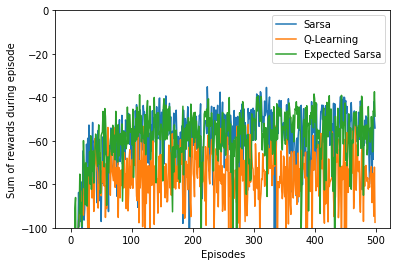

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CliffWalking-v0")
test_episodes = 500
runs = 50
rewards_q = np.zeros(test_episodes)
rewards_sarsa = np.zeros(test_episodes)
rewards_expected_sarsa = np.zeros(test_episodes)
for i in range(runs):
    q_agent = TabularQLearner(env, episodes=test_episodes, gamma=1, eps=0.1, alpha=0.5, decaying_eps=False)
    sarsa_agent = TabularSarsaLearner(env, episodes=test_episodes, gamma=1, eps=0.1, alpha=0.5, decaying_eps=False)
    expected_sarsa_agent = TabularExpectedSarsaLearner(env, episodes=test_episodes, gamma=1, eps=0.1, alpha=0.5, decaying_eps=False)
    rewards_q += q_agent.learn()
    rewards_sarsa += sarsa_agent.learn()
    rewards_expected_sarsa += expected_sarsa_agent.learn()

rewards_q /= runs
rewards_sarsa /= runs
rewards_expected_sarsa /= runs

# draw reward curves
plt.plot(rewards_sarsa, label='Sarsa')
plt.plot(rewards_q, label='Q-Learning')
plt.plot(rewards_expected_sarsa, label='Expected Sarsa')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.ylim([-100, 0])
plt.legend()

plt.show()